In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime

warnings.filterwarnings('ignore')

from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

In [4]:
dat = nc.Dataset('../static_maps/MCD12C1.A2020001.006.2021362215328.hdf')
print(dat)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF4):
    HDFEOSVersion: HDFEOS_V2.19
    StructMetadata.0: GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="MOD12C1"
		XDim=7200
		YDim=3600
		UpperLeftPointMtrs=(-180000000.000000,90000000.000000)
		LowerRightMtrs=(180000000.000000,-90000000.000000)
		Projection=GCTP_GEO
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Num_IGBP_Classes"
				Size=17
			END_OBJECT=Dimension_1
			OBJECT=Dimension_2
				DimensionName="Num_UMD_Classes"
				Size=16
			END_OBJECT=Dimension_2
			OBJECT=Dimension_3
				DimensionName="Num_LAI_FPAR_Classes"
				Size=11
			END_OBJECT=Dimension_3
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Majority_Land_Cover_Type_1"
				DataType=DFNT_UINT8
				DimList=("YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Majority_Land_Cover_Type_1_Assessment"


In [3]:
lc = dat['Majority_Land_Cover_Type_1'][:]
lc_flipped = np.flipud(lc)
print(lc.shape)

lc_percent = dat['Land_Cover_Type_1_Percent'][:]
lc_percent_flipped = np.flipud(lc_percent)
print(lc_percent.shape, lc_percent_flipped.shape)
lc_percent_flipped = np.swapaxes(np.swapaxes(lc_percent_flipped, 0,2), 1,2)
print(lc_percent_flipped.shape)

(3600, 7200)
(3600, 7200, 17) (3600, 7200, 17)
(17, 3600, 7200)


(3601,) (7201,)
(3600,) (7200,)
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


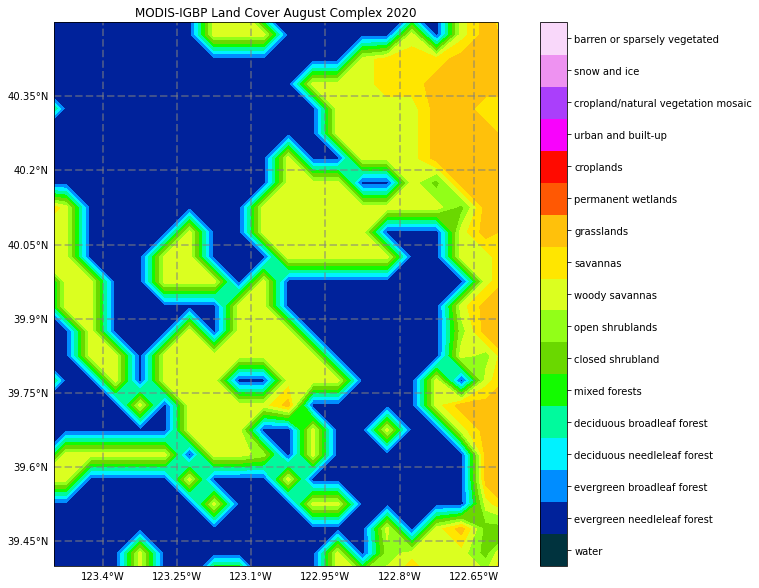

[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


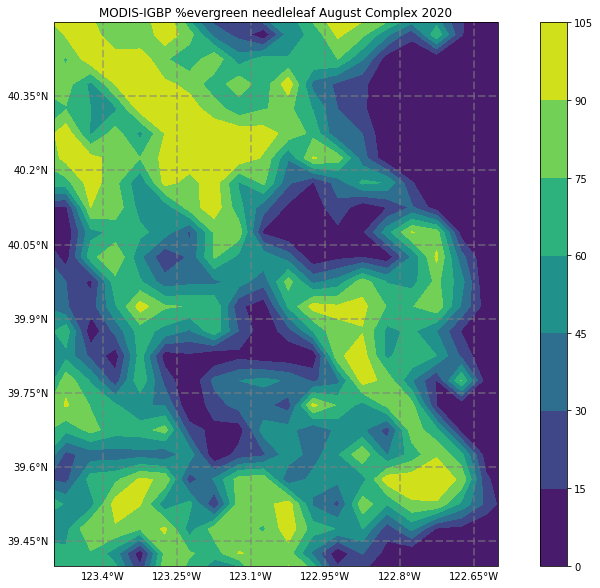

In [45]:
lat_corners = np.arange(-90, 90.05, 0.05)
lon_corners = np.arange(-180, 180.05, 0.05)
print(lat_corners.shape, lon_corners.shape)

lat_centers = (lat_corners[0:len(lat_corners)-1] + lat_corners[1:len(lat_corners)])/2
lon_centers = (lon_corners[0:len(lon_corners)-1] + lon_corners[1:len(lon_corners)])/2
print(lat_centers.shape, lon_centers.shape)
LON_CORNER, LAT_CORNER = np.meshgrid(lon_corners, lat_corners)
LON_CENTER, LAT_CENTER = np.meshgrid(lon_centers, lat_centers)

lat_inds = np.where((lat_centers>=31)& (lat_centers<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_centers>=-126)& (lon_centers<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]


fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-123.5, -122.6, 39.4, 40.5])
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#CS = plt.contourf(X, Y, Z, levels=levels, cmap=cm.coolwarm, extend='min')

levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
print(levels)
fuelmap = plt.contourf(LON_CENTER[lat_start:lat_end, lon_start:lon_end],\
            LAT_CENTER[lat_start:lat_end, lon_start:lon_end],\
           lc_flipped[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')

#plt.scatter(-96.775367, 43.487384,marker='*', c = 'y', s =500)
colorbar = plt.colorbar(fuelmap, ticks = np.arange(0, 17, 1))

fuel_labels = ['water', 'evergreen needleleaf forest', 'evergreen broadleaf forest', 'deciduous needleleaf forest', \
               'deciduous broadleaf forest', 'mixed forests', 'closed shrubland', 'open shrublands', 'woody savannas',\
               'savannas', 'grasslands', 'permanent wetlands', 'croplands', 'urban and built-up',\
               'cropland/natural vegetation mosaic', 'snow and ice ', 'barren or sparsely vegetated']
colorbar.set_ticklabels(ticklabels = fuel_labels)
plt.title('MODIS-IGBP Land Cover August Complex 2020')
plt.show()



fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-123.5, -122.6, 39.4, 40.5])
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
#CS = plt.contourf(X, Y, Z, levels=levels, cmap=cm.coolwarm, extend='min')

#levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
print(levels)
percentmap = plt.contourf(LON_CENTER[lat_start:lat_end, lon_start:lon_end],\
            LAT_CENTER[lat_start:lat_end, lon_start:lon_end],\
           lc_percent_flipped[1,lat_start:lat_end, lon_start:lon_end],\
            cmap='viridis')
colorbar = plt.colorbar(percentmap)
plt.title('MODIS-IGBP %evergreen needleleaf August Complex 2020')
plt.show()

## Save the geolocated fuel data as a netcdf

In [41]:
ncfile = nc.Dataset('../static_maps/MODIS_IGBP_2020.nc',mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 


In [42]:
#defining dimensions
lat_dim = ncfile.createDimension('lat', len(lat_centers))     # latitude axis
lon_dim = ncfile.createDimension('lon', len(lon_centers))    # longitude axis
time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
for dim in ncfile.dimensions.items():
    print(dim)

('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 3600)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 7200)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)


In [43]:
#defining variables
lat = ncfile.createVariable('lat', np.float32, ('lat','lon'))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lon = ncfile.createVariable('lon', np.float32, ('lat','lon'))
lon.units = 'degrees_east'
lon.long_name = 'longitude'

# Define a 3D variable to hold the data
lc_majority = ncfile.createVariable('lc_majority',np.float64,('lat','lon')) # note: unlimited dimension is leftmost
lc_majority.units = '#' # degrees Kelvin
lc_majority.standard_name = 'majority_igbp_category' # this is a CF standard name
print(lc_majority)

lc_percent= ncfile.createVariable('lc_percent',np.float64,('time','lat','lon')) # note: unlimited dimension is leftmost
lc_percent.units = '#' # degrees Kelvin
lc_percent.standard_name = 'percent_igbp_category' # this is a CF standard name
print(lc_percent)

<class 'netCDF4._netCDF4.Variable'>
float64 lc_majority(lat, lon)
    units: #
    standard_name: majority_igbp_category
unlimited dimensions: 
current shape = (3600, 7200)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float64 lc_percent(time, lat, lon)
    units: #
    standard_name: percent_igbp_category
unlimited dimensions: time
current shape = (0, 3600, 7200)
filling on, default _FillValue of 9.969209968386869e+36 used


In [9]:
print(lat, lon)

<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat, lon)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (3600, 7200)
filling on, default _FillValue of 9.969209968386869e+36 used <class 'netCDF4._netCDF4.Variable'>
float32 lon(lat, lon)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (3600, 7200)
filling on, default _FillValue of 9.969209968386869e+36 used


In [44]:
lat[:] = LAT_CENTER[:]
lon[:] = LON_CENTER[:]
lc_majority[:] = lc_flipped[:]
lc_percent[:] = lc_percent_flipped[:]
# first print the Dataset object to see what we've got
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): lat(3600), lon(7200), time(17)
    variables(dimensions): float32 lat(lat, lon), float32 lon(lat, lon), float64 lc_majority(lat, lon), float64 lc_percent(time, lat, lon)
    groups: 
Dataset is closed!


## Code Testing

In [ ]:
from pyhdf import SD
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
hdf = SD.SD('../static_maps/MCD12C1.A2020001.006.2021362215328.hdf')
data = hdf.select('Majority_Land_Cover_Type_1')
snowcover=np.array(data[:,:],np.float)
snowcover[np.where(snowcover==255)]=np.nan

fig = plt.figure(figsize=(15,10))
m = Basemap(projection='cyl', resolution = 'l',
    llcrnrlat=-90, urcrnrlat=90,llcrnrlon=-180,urcrnrlon=180,\
           width=25,height=19,lat_0=40.5,lon_0=-113.5)
cdict = {'red' : [(0,0.,0.), (100./255.,1.,1.),(1.,0.,0.)],
         'green' : [(0,0.,0.),(1.,0.,0.)] , 
         'blue' : [(0,0.,0.),(100./255.,0.,0.),(1.,1.,1.)] }
blue_red = LinearSegmentedColormap('BlueRed',cdict)

m.drawcoastlines(linewidth=0.5)
m.drawparallels(np.arange(-90,120,30), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180,181,45),labels=[0,0,0,1])
m.imshow(snowcover,cmap=blue_red)
#m.set_extent([-126, -101, 31, 50])
plt.colorbar()
plt.title('MCD12C1: IGBP Fuels')
plt.show()

print(m)

# from here: https://stackoverflow.com/questions/51557613/lat-lon-information-from-hdf-file-python

In [35]:
lat_corners = np.arange(-90, 90.05, 0.05)
lon_corners = np.arange(-180, 180.05, 0.05)
print(lat_corners.shape, lon_corners.shape)

lat_centers = (lat_corners[0:len(lat_corners)-1] + lat_corners[1:len(lat_corners)])/2
lon_centers = (lon_corners[0:len(lon_corners)-1] + lon_corners[1:len(lon_corners)])/2
print(lat_centers.shape, lon_centers.shape)
LON_CORNER, LAT_CORNER = np.meshgrid(lon_corners, lat_corners)
LON_CENTER, LAT_CENTER = np.meshgrid(lon_centers, lat_centers)

(3601,) (7201,)
(3600,) (7200,)


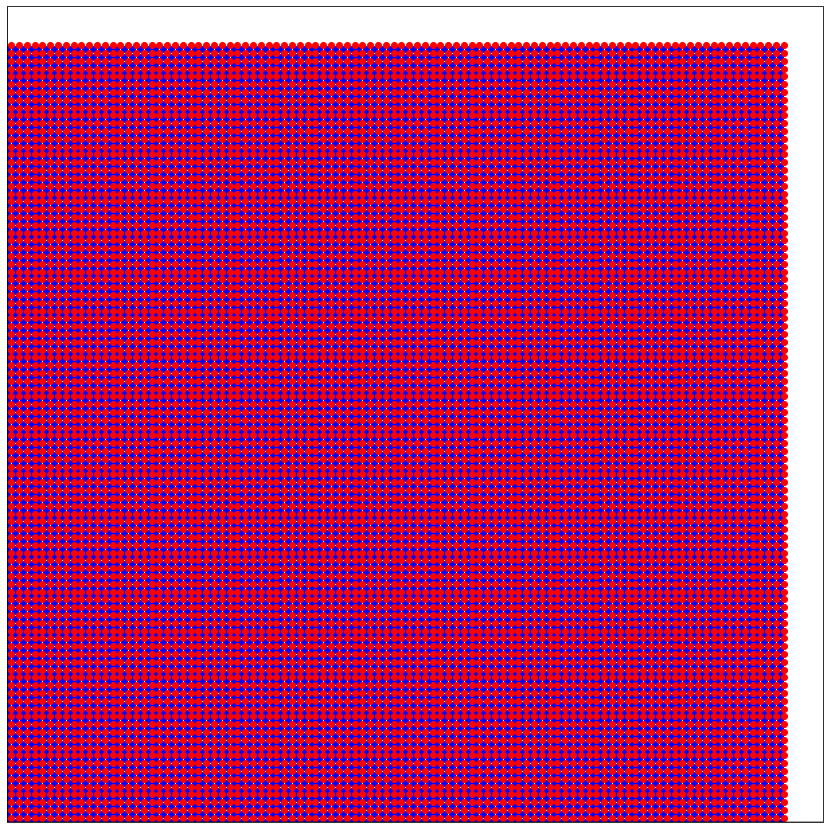

In [38]:
fig = plt.figure(figsize=(20,15))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
plt.scatter(LON_CORNER[0:100, 0:100], LAT_CORNER[0:100, 0:100], c='b')
plt.scatter(LON_CENTER[0:100, 0:100], LAT_CENTER[0:100, 0:100], c='r')
plt.show()